In [1]:
import torch
# Setup device agnostic code 
device = "cuda" if torch.cuda.is_available() else 'cpu'

## Get Data

In [2]:
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/"train"
test_dir=image_path/"test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [5]:
from torchvision import transforms
from going_modular import data_setup
# Create img size 
IMG_SIZE = 224 # Table 3 from ViT Paper 

# Create transforms pipline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Create a batch size of 32 (paper uses 4096 batch size)
BATCH_SIZE = 32

# Create DataLoaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [7]:
# Get a batch of images 
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch 
image, label = image_batch[0], label_batch[0]

# View the batch shape 
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

Text(0.5, 1.0, 'steak')

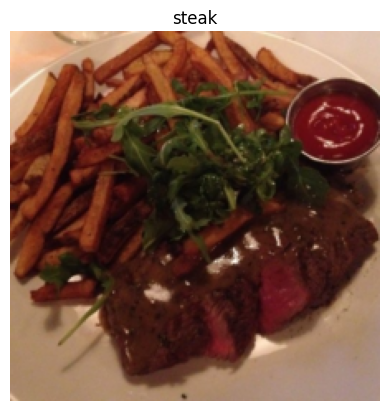

In [8]:
# Plot the image 
import matplotlib.pyplot as plt 
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

## Replication ViT: Overview
## Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

* Input shape:HxWxC (224,224,3) -> (height, width, color channels)
* Output shape: N x (P^2 . C)
* H = height
* W = Width
* C = color channels
* P = patch size 
* N = number of patches = (height*width)/p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
# Create example values 
height = 224 
width = 224 
color_channels = 3
patch_size = 16

# Calculate number of patches 
number_of_patches = int((height*width)/patch_size**2)
number_of_patches 

196

In [10]:
# Input shape 
embedding_layer_input_shape = (height, width, color_channels)
# Output shape 
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)
embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

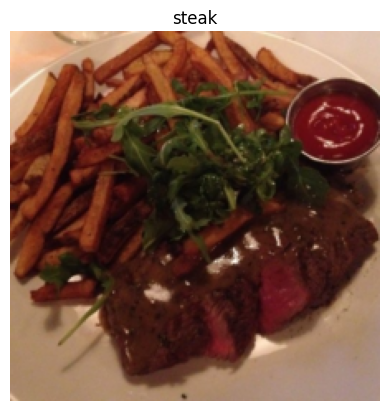

In [11]:
# View a single image 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [12]:
image.shape

torch.Size([3, 224, 224])

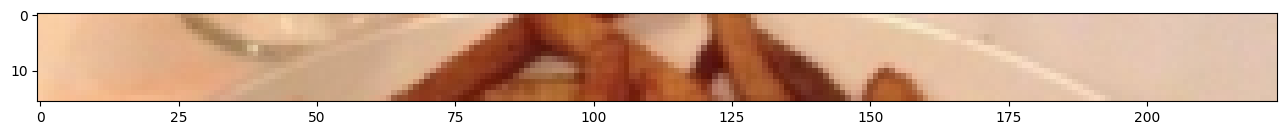

In [13]:
# Get the top row of the image 
image_permuted = image.permute(1,2,0) # (H,W,C)
# Index to plot the top row of pixels
patch_size = 16 
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


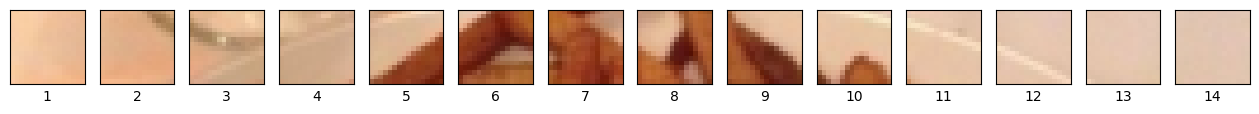

In [14]:
# Setup code to plot top row as patches 
img_size = 224 
patch_size = 16 
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size."
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')
# Create a series of subplot 
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))
# Iterate through number of patches in top row 
for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'steak -> Patchified')

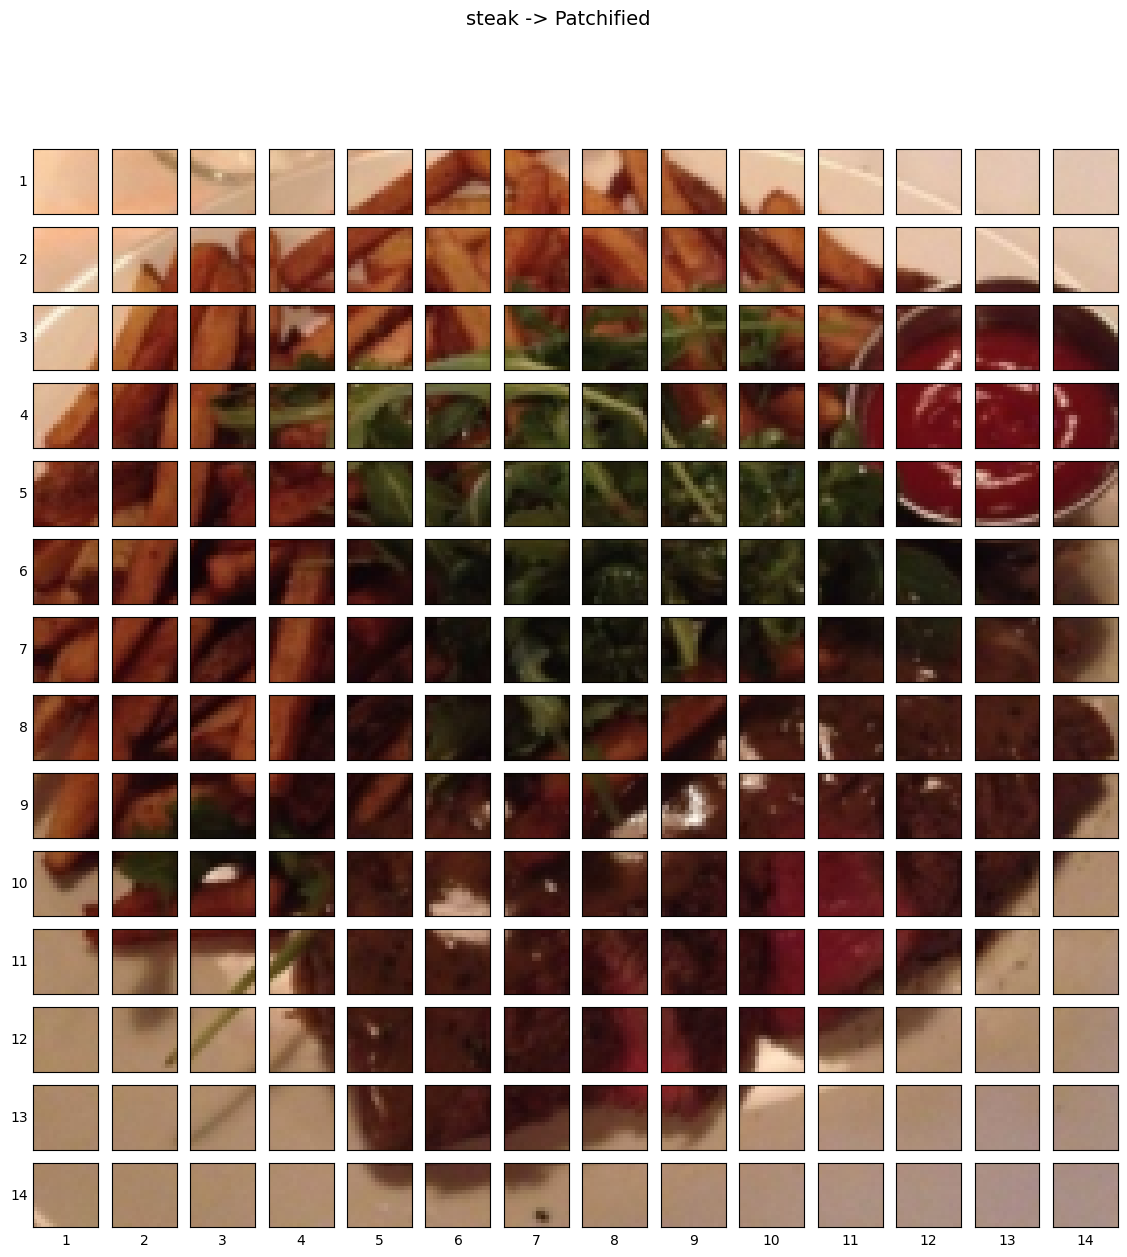

In [15]:
# Setup code to plot whole image as patch
img_size = 224 
patch_size = 16 
num_patches = img_size/patch_size 
assert img_size%patch_size==0, "Image size must be divisible by patch size."
print(f'''Number of patches per row: {num_patches}
Number of patches per column: {num_patches}
Total patches: {num_patches*num_patches}
Patch size: {patch_size} pixels x {patch_size} pixels''')

# Create a series of subplots 
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
# Loop through height and width 
for i, patch_height in enumerate(range(0,img_size,patch_size)):
    for j, patch_width in enumerate(range(0,img_size, patch_size)):
        # Plot the permuted image on different axis 
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                       patch_width:patch_width+patch_size, 
                                       :])
        axs[i,j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=14)

### Creating image patches and turning into image embeddings

We can create the image patches and image patch embedding in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`. 

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn  
# Set the patch size 
patch_size = 16 
# Create a conv2d layer with hyperparameters from ViT paper 
conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768, # D size from table 1 
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

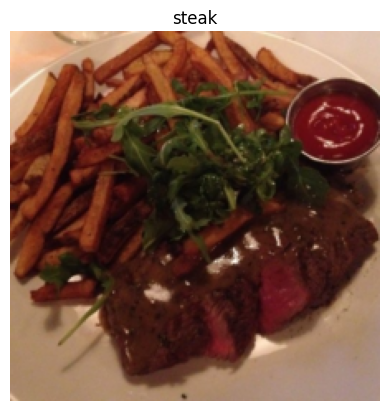

In [17]:
# View single image 
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

In [18]:
# Patch the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channel, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is 

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

In [19]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [708, 460, 593, 215, 611]


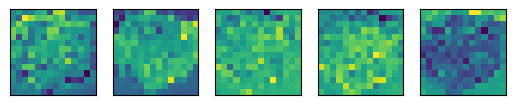

In [20]:
# Plot random convolutional feature maps (embeddings)
import random 
random_indexs = random.sample(range(0,758),k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexs}')

# Create plot 
fig, axs = plt.subplots(nrows=1,ncols=5)

for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())# squueze->removes batch dimension, detach -> removed grads, numpy -> turns to the numpy array 
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [21]:
# Get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.7327, -0.6905, -0.5897, -0.6882, -0.3916, -0.3216, -0.3431,
           -0.2911, -0.2627, -0.6362, -0.8068, -0.7827, -0.7745, -0.7819],
          [-0.7710, -0.4550, -0.1955, -0.2126, -0.3805, -0.3184, -0.2078,
           -0.2637, -0.3538, -0.1318, -0.2382, -0.6109, -0.7274, -0.8384],
          [-0.6911, -0.2684, -0.1907, -0.2311, -0.4696, -0.1329, -0.1019,
           -0.1042, -0.1886, -0.1643, -0.4046, -0.2959, -0.2149,  0.0121],
          [-0.3087, -0.2731, -0.2465, -0.2801, -0.1022, -0.1300, -0.1475,
           -0.2839, -0.2321, -0.1825, -0.1886, -0.0919, -0.1386, -0.3211],
          [-0.2470, -0.2255, -0.2067, -0.1836, -0.1644, -0.1709, -0.1469,
           -0.2832, -0.2824, -0.2233, -0.1135, -0.3332, -0.1618, -0.5539],
          [-0.1187, -0.1238, -0.0421, -0.2071, -0.0780, -0.1060, -0.1161,
           -0.1302, -0.0806, -0.2090, -0.0894, -0.1443, -0.0770, -0.3035],
          [-0.3357, -0.2317, -0.2252, -0.1449, -0.1353, -0.0936, -0.1294,
           -0.1103, -0.2142, -0.

### Flattening the patch embedding with `torch.nn.Flatten()` 

In [22]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [23]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


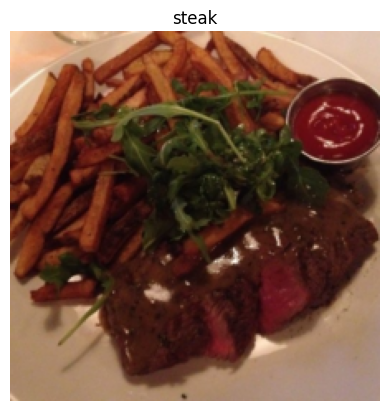

In [24]:
# Put everything together 
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')
# Turn image into feature maps 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps 
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')


In [25]:
# Rearrange output of flattened layer 
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f'{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimension)')

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


(-0.5, 195.5, 0.5, -0.5)

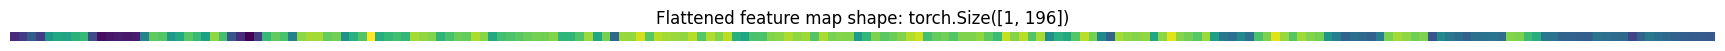

In [26]:
# Get a single flattend feature map 
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
# Plot the flattend feature map 
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

### Turning the ViT patch embedding layer into a PyTorch module 

We want this module to do:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines forward computation.
6. Make sure the output of the layer reflects the required output shape of the patch embedding.

In [27]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # 3. Create a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # 4. Create a layer to flatten feature map outputs of Conv2d
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    # 5. Define forward method to define forward computation steps
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution%patch_size==0, f"Imput image size must be divisible by patch size, image shape: {image_resolution}, potch size: {self.patch_size}"
        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimensions)
        return x_flattened.permute(0,2,1)

In [28]:
set_seeds()
# Create an instance of patch embedding layer 
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
# Pass a single image from the embedding layer 
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension 
print(f'Output patch embedding sequeence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequeence shape: torch.Size([1, 196, 768])


In [29]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.rand(1,3,250,250)
patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding

In [30]:
patch_embedded_image

tensor([[[-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
         [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
         [-0.6605,  0.1877, -0.1303,  ...,  0.5441, -0.3703,  0.3336],
         ...,
         [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
         [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
         [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Get the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# Create token embedding as a learnable parameter that shares the same size as the embedding dimension ( D )
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Add the class token embedding to the front of the patch embedding 
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                       dim=1)
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of the patch embeddings with class token prepend shape: {patch_embedded_image_with_class_embedding.shape} -> (bathc_size, class_token + number_of_patchs, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
         [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
         ...,
         [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
         [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
         [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
       grad_fn=<CatBackward0>)
Sequence of the patch embeddings with class token prepend shape: torch.Size([1, 197, 768]) -> (bathc_size, class_token + number_of_patchs, embedding_dim)


### Creating the position embedding
Want to: create a series of 1D learnable position embedding and to add them to the sequence of patch embeddings 

In [35]:
# View the sequence of patch embeddings with the prepended class embedding 
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8384,  0.1266, -0.1849,  ...,  0.5783, -0.4258,  0.3485],
          [-0.8006,  0.0782, -0.1662,  ...,  0.5228, -0.3607,  0.2894],
          ...,
          [-0.6366,  0.1312, -0.1539,  ...,  0.4373, -0.2923,  0.2290],
          [-0.6329,  0.1262, -0.1610,  ...,  0.4436, -0.2940,  0.2314],
          [-0.6350,  0.1342, -0.1575,  ...,  0.4512, -0.2926,  0.2287]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension 
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create a learnable 1D position embedding 
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [37]:
# Add the position embedding to the patch and class token embedding 
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1616, 1.1266, 0.8151,  ..., 1.5783, 0.5742, 1.3485],
         [0.1994, 1.0782, 0.8338,  ..., 1.5228, 0.6393, 1.2894],
         ...,
         [0.3634, 1.1312, 0.8461,  ..., 1.4373, 0.7077, 1.2290],
         [0.3671, 1.1262, 0.8390,  ..., 1.4436, 0.7060, 1.2314],
         [0.3650, 1.1342, 0.8425,  ..., 1.4512, 0.7074, 1.2287]]],
       grad_fn=<AddBackward0>)
patch and position embedding shape: torch.Size([1, 197, 768])


### Putting it all together: from image to embedding 

In [38]:
# Set seed 
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of the original image and get the image dimesions 
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension 
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer 
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedding layer 
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. Create a class token embedding 
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f'Class token embedding shape: {class_token.shape}')
# 7. Prepend the class token embedding to patch embedding 
patch_embedding_class_token = torch.cat((class_token , patch_embedding), 
                                        dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. Create position embedding 
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
# 9. Add position embedding to patch embedding with class token 
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape} -> [batch, sequence, feature]')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) -> [batch, sequence, feature]


## Equation 2: Multihead Self-Attention (MSA block)

In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)"""
    def __init__(self, 
                 embedding_dimension:int=768, # Hidden size D (embedding dimension) from table 1
                 num_heads:int=12, #Heads from table 1
                 attn_dropout:int=0):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension, 
                                                    num_heads=num_heads, 
                                                    dropout=attn_dropout,
                                                    batch_first=True) # is batch first ? (batch, seq, feature) -> (batch, number_of_patches, embedding_dim)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output 
        

In [40]:
# Create an instance MSA block 
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dimension=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass the patch and position image embedding sequence through MSA block 
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


### Equation 3: MultiLayer Perceptron block

* **MLP** = The MLP contain two layers with a GELU non-linearity (section 3.1)

```python
#MLP 
x = Linear -> non-linear -> droput -> linear -> dropout
```

In [41]:
class MLPBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        # Create the MLP 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dimension,
                    out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                    out_features=embedding_dimension),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [42]:
# Create an instance of MLPBlock 
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass output of the MSA Block through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## Creating the Transformer Encoder

The transformer Encoder is a combination of alternating blocks of MSA (euqation 2) and MLP (equation 3)

```python
#Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### Create a custom Transformer Encoder Layer

In [43]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dimension=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [45]:
from torchinfo import summary

# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\Thoyajaksha Kashyap\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create a Transformer Encoder Layer with in-built PyTorch Layers

In [46]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1  
                                                       nhead=12, # heads from table 1
                                                       dim_feedforward=3072, #MLP Size
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT

In [48]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self, 
                 img_size:int=224, # Table 3 from the ViT paper
                 in_channels:int=3, 
                 patch_size:int=16,
                 num_transformer_layers:int=12, # Table 1 for "Layers" from ViT_Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # Table 1
                 num_heads:int=12, # Table 1
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # number of classes in our classification problem
        super().__init__()
        # Make an assertion that image size is compatible with the patch size 
        assert img_size%patch_size==0, f'Image size must be divisible by patch size, image: {img_size}, patch size: {patch_width}'
        # Calculate the number of patches (height*width/patch**2)
        self.num_patches=(img_size*img_size) // patch_size**2
        # Create learnable class embedding (needs to go at the front of sequence of patch embedding)
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True)
        # Create learnable position embedding 
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim))
        # Create embedding dropout value 
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        # Create patch embedding layer 
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # Create the transformer encoder block 
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # Create classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )        
    
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        # Create class token embedding and expand it to match the batch size (eqution 1)
        class_token = self.class_embedding.expand(batch_size,-1,-1)
        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)
        # Concat class  token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches+1, embedding_dim)
        # Add position embedding to class token and patch embedding 
        x = self.position_embedding + x
        # Add dropout to patch embedding 
        x = self.embedding_dropout(x)
        # Pass position and patch embedding to transformer (equation 2 and 3)
        x = self.transformer_encoder(x)
        # Put  0th index logit through classifier (equation 4)
        x = self.classifier(x[:,0])
        return x        

In [49]:
set_seeds()
#Create a random image tensor with same shape as a single image 
random_image_tensor = torch.randn(1,32,224,224)
# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))
# Pass the random image tensor to our ViT instance
vit(rand_image_tensor)

tensor([[ 0.3361,  0.2240, -1.4273]], grad_fn=<AddmmBackward0>)

### Getting a visual summary of our ViT model

In [50]:
from torchinfo import summary 

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Setting up training code for our custom ViT 

### Creating an optimizer

In [51]:
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)

### Creating a loss function

In [52]:
loss_fn = torch.nn.CrossEntropyLoss()

### Train our ViT Model

In [53]:
from going_modular import engine
set_seeds() 
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7545 | train_acc: 0.3711 | test_loss: 1.1838 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1465 | train_acc: 0.4219 | test_loss: 2.6441 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.0147 | train_acc: 0.2852 | test_loss: 1.4513 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.7859 | train_acc: 0.2734 | test_loss: 1.2708 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3097 | train_acc: 0.2852 | test_loss: 1.0383 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2256 | train_acc: 0.2930 | test_loss: 1.2893 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1945 | train_acc: 0.3945 | test_loss: 2.6886 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4505 | train_acc: 0.3047 | test_loss: 1.2568 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2792 | train_acc: 0.2461 | test_loss: 1.1299 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3102 | train_acc: 0.4297 | test_loss: 1.4247 | test_acc: 0.2604


### Plotting loss curves for our model

In [54]:
results

{'train_loss': [3.754483863711357,
  1.1465066745877266,
  2.0146600157022476,
  1.7858611941337585,
  1.3097314983606339,
  1.225611925125122,
  1.1945452690124512,
  1.4505228996276855,
  1.2791580706834793,
  1.3102100938558578],
 'train_acc': [0.37109375,
  0.421875,
  0.28515625,
  0.2734375,
  0.28515625,
  0.29296875,
  0.39453125,
  0.3046875,
  0.24609375,
  0.4296875],
 'test_loss': [1.183789809544881,
  2.644093871116638,
  1.4512749115626018,
  1.2708204984664917,
  1.0383321444193523,
  1.289261817932129,
  2.6886484622955322,
  1.2567627628644307,
  1.1298826535542805,
  1.4246839086214702],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.19791666666666666,
  0.5416666666666666,
  0.19791666666666666,
  0.19791666666666666,
  0.2604166666666667,
  0.5416666666666666,
  0.2604166666666667]}

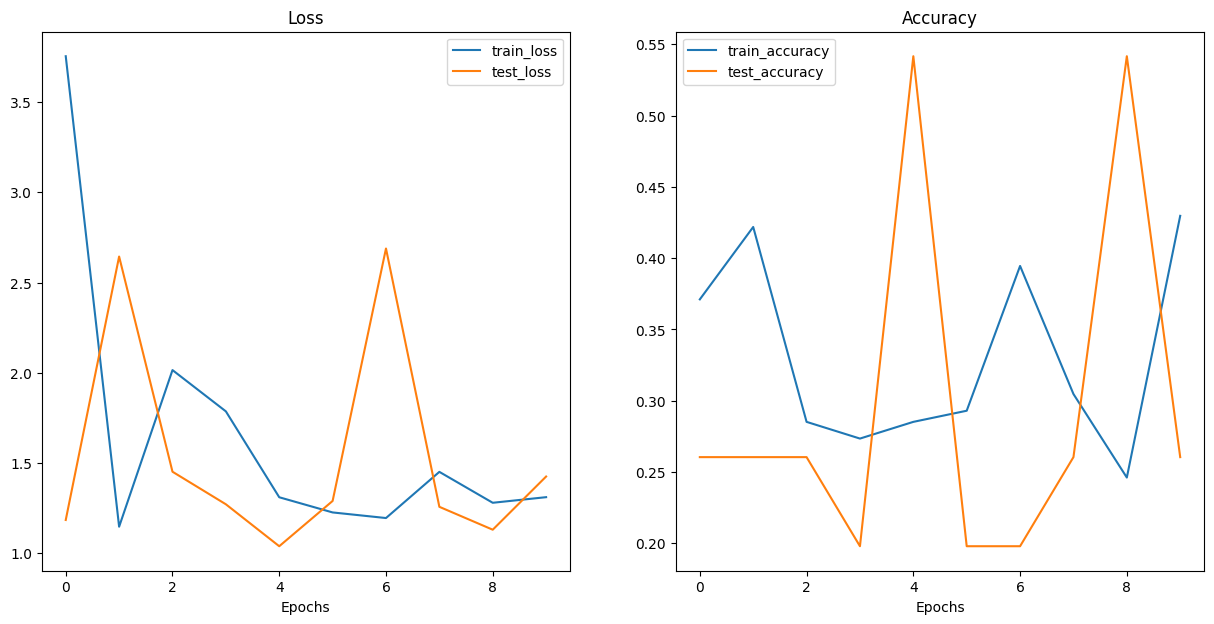

In [55]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## Using a pretrained ViT from `torchvision.models`

In [56]:
import torch 
import torchvision 
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cpu


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [58]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT = best available
# Setup a ViT model instance with pretrained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base pzrameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False
    
# Update the classifier head 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

In [59]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [60]:
# Number of parameters in pretrained ViT 
num_params = 85,800,963 
num_params

(85, 800, 963)

### Preparing data for the pretrained ViT model 

In [63]:
# Get automatic transforms from pretrained viT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [64]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### Train feature extractor ViT model

In [66]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### Plot the loss curves of our pretrained ViT feature extractor

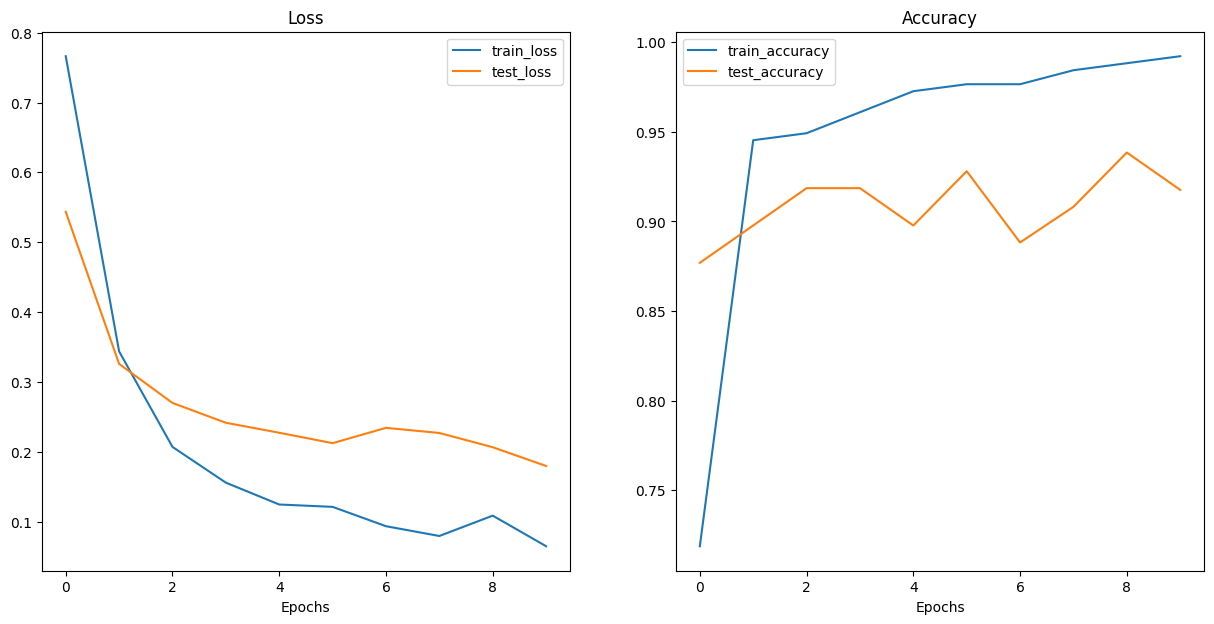

In [67]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Save our best performing ViT model 

In [68]:
# Save the model 
from going_modular import utils 
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor.pth


In [71]:
from pathlib import Path 
# Get the model size in bytes then convert to megabytes 
pretrained_vit_model_size = Path( "models/pretrained_vit_feature_extractor.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT features extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT features extractor model size: 327 MB


## Predicting on custom image

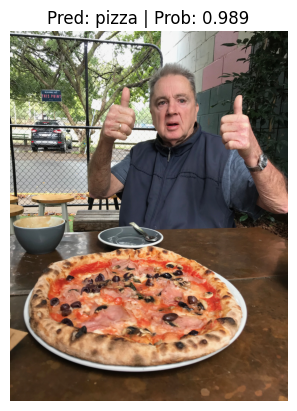

In [75]:
from going_modular.predictions import pred_and_plot_image

custom_image_path  = image_path / "04-pizza-dad.jpeg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)